## Imports

In [413]:
import numpy as np
import einops
import copy
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

import importlib

In [414]:
import bonds
import lattice
import utils
import plot_utils

In [415]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)


## Set up lattice

### Kagome bow tie

In [416]:
# lattice params for kagome lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

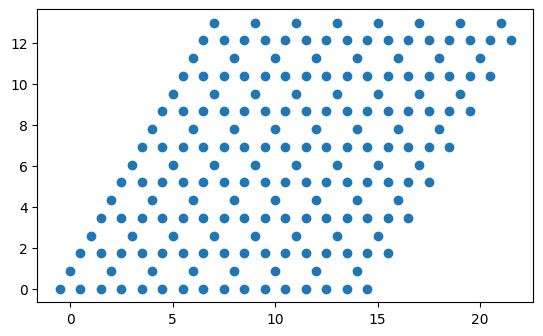

In [417]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [418]:
height = np.sqrt(3)/2
# polygon = lattice.create_hexagon(5.1, 7, 5 * height)
polygon = lattice.create_hexagon(6.1, 10, 7 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

# ebSpecs = bonds.Bonds(
#     polygon_ebs = [
#         polygon, polygon, polygon, polygon, polygon, polygon
#     ], 
#     unit_cell_bases_ebs = [
#         np.array([0, height]), 
#         np.array([1.5, 0.]),
#         np.array([0.5, 0.]),
#         np.array([0., height]),
#         np.array([-0.5, 0.]),
#         np.array([0.5, 0.]),
#     ]    
# )

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        polygon, polygon, polygon, polygon, 
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0.5, 0.]), 
    ]    
)

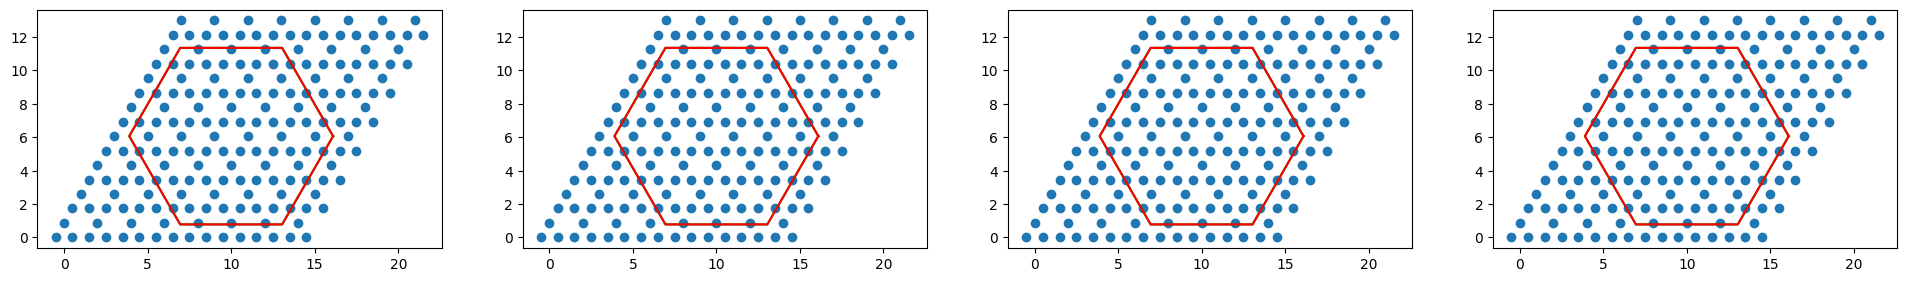

In [419]:
num_configs_loop = len(ebSpecs.polygon_ebs)
fig, axes = plt.subplots(1, num_configs_loop, figsize=(6 *num_configs_loop, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [420]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

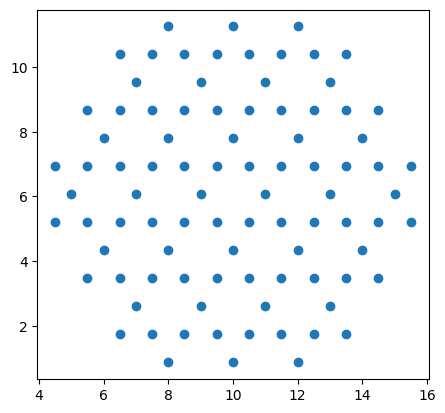

In [421]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=90 and $N_{\\rm bonds}=$162')

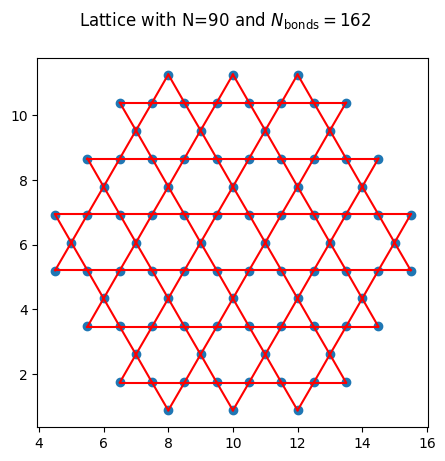

In [422]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [423]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

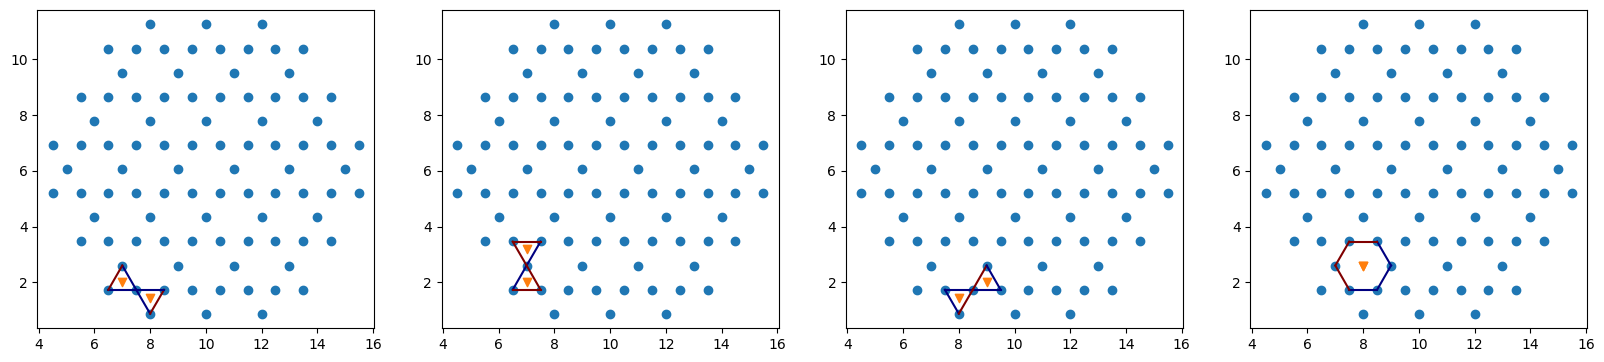

In [424]:
num_config_loops = len(ebSpecs.unit_cell_bases_ebs)
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs[:1]):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

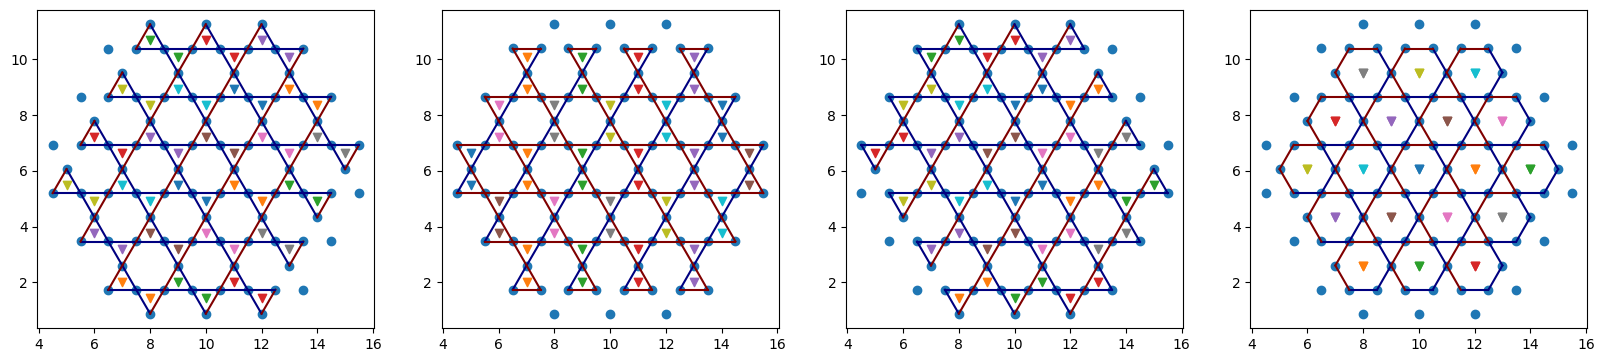

In [425]:
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Saddle point 

In [426]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [427]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

In [428]:
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5 * np.ones_like(Q_init))
# results_gs = minimize(energy_Q, Q_init, method='trust-constr',
#                constraints=linear_constraint,
#                options={'verbose': 1})
results_gs = minimize(energy_Q, Q_init)

In [429]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-44.68467921327436
True
Optimization terminated successfully.
0


array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

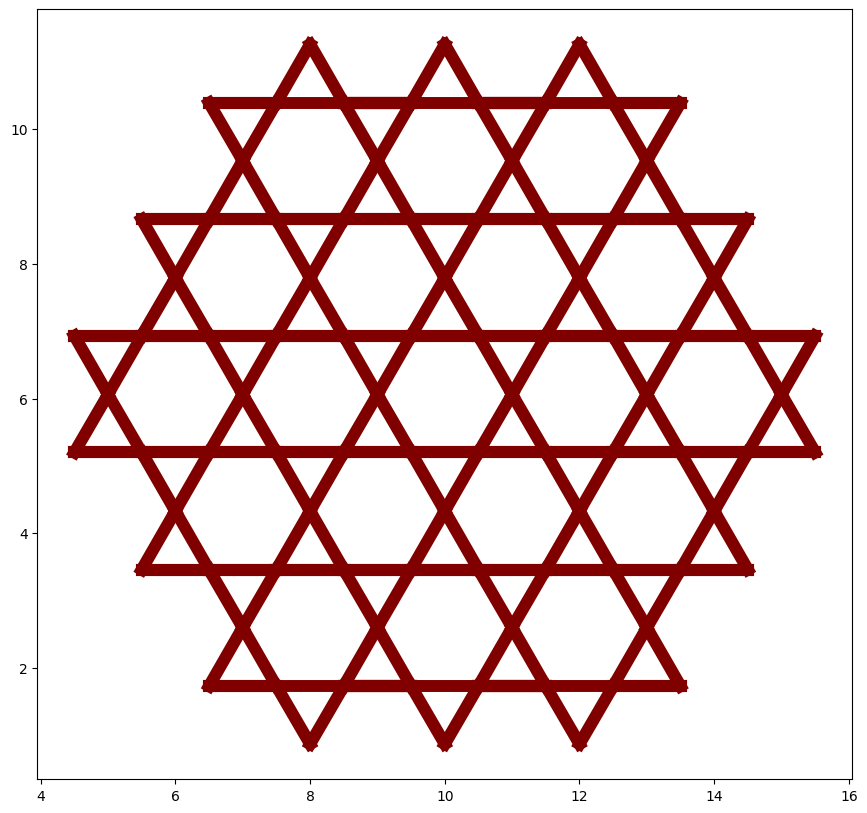

In [430]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$\bar{Q}^0=$" + f"{np.mean(results_gs['x']):.2f}", (2., 5.5), size=25)
  # ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison


In [431]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    v_pt=np.array([10, 7 * height]),
    visonBonds_vs = [np.array([[10.5, 6 * height], [11., 7 * height]]),
                 np.array([[10.5, 6 * height], [11.5, 6. * height]]), 
              np.array([[11.5, 6. * height], [12.,  5 * height]]), 
              np.array([[12.,  5 * height], [12.5, 6 *height]]), 
              np.array([[13.5, 4 *height], [14, 5 * height]]),
                     np.array([[13.5, 4 *height], [14.5, 4 * height]]),
              ]
)              
visonBonds_idx = []
print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

print(f"final value of Q_init is {Q_init}")

initial value of Q_init is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
final value of Q_init is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

In [432]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

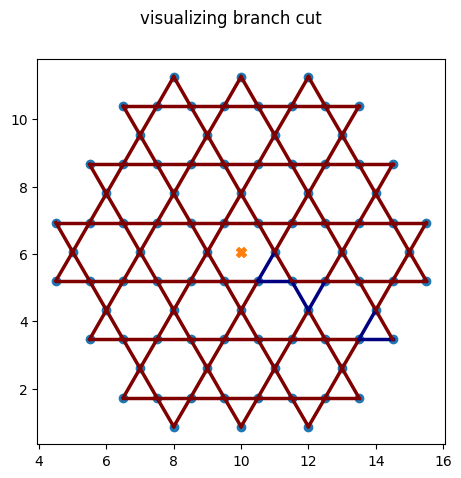

In [433]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [434]:
results_gs['x']

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [435]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy(couplings, Q_init_vs, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 29829, CG iterations: 1357, optimality: 6.87e-07, constraint violation: 0.00e+00, execution time: 7.6e+02 s.


In [436]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [437]:
results_gs['x']

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [438]:
energy_Q(Q_init)

-26.5

In [439]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-44.941560379046415
True
`xtol` termination condition is satisfied.
2


array([ 0.76322454,  0.73803   ,  0.76322454,  0.73802999,  0.78909603,
        0.73947868,  0.76542125,  0.76675339,  0.78909604,  0.73803002,
        0.76322453,  0.76769478,  0.76322452,  0.76322452,  0.76542125,
        0.76675343,  0.78909604,  0.73947869,  0.76889219,  0.76624203,
        0.76889215,  0.76624207,  0.77071865,  0.76624203,  0.76795731,
        0.76903079,  0.76889215,  0.7667534 ,  0.76769479,  0.76795731,
       -0.76542125,  0.76542126,  0.76322455,  0.76769478,  0.78909604,
        0.73803001,  0.7679573 ,  0.7690308 ,  0.77071864,  0.76624208,
        0.78111349,  0.83376794,  0.78111348,  0.83376792, -0.7811135 ,
        0.76903078, -0.76903078,  0.7811135 ,  0.76795731,  0.76769479,
        0.76675338,  0.76889218,  0.76322452,  0.76322451,  0.76322452,
        0.76322453,  0.76769478,  0.7679573 ,  0.76889219,  0.7667534 ,
        0.76903078,  0.78111347,  0.78111349,  0.76903079,  0.83376793,
        0.78111349,  0.83376793,  0.78111351,  0.76903077,  0.76

In [440]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [441]:
Q0_results

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

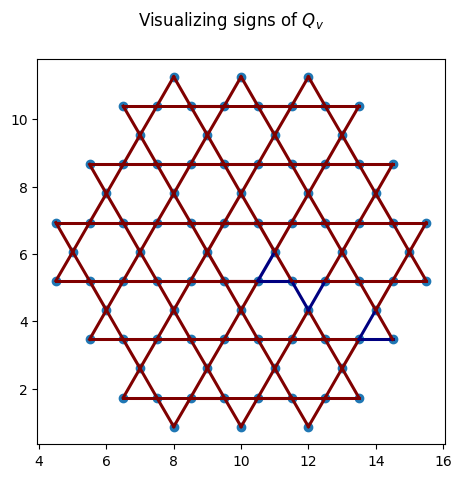

In [442]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [443]:
Qv_results - Q0_results

array([-1.46225149e-05, -2.74238037e-05, -1.44119539e-05, -2.70965979e-05,
       -4.84016196e-05, -1.81185850e-04, -3.42614514e-05, -1.73946431e-04,
       -4.89901357e-05, -2.77066416e-05, -1.49373563e-05, -6.39719735e-05,
       -1.49793243e-05, -1.46420250e-05, -3.58132408e-05, -1.74959164e-04,
       -4.94539017e-05, -1.81251463e-04,  2.40666040e-04, -9.12382599e-04,
        2.40949235e-04, -9.12473296e-04,  4.11726318e-03, -9.13113786e-04,
        1.33346301e-04,  3.10302063e-03,  2.40949457e-04, -1.73641584e-04,
       -6.35716271e-05,  1.33490425e-04, -1.53087774e+00, -3.52371608e-05,
       -1.49989074e-05, -6.32691384e-05, -4.92271271e-05, -2.74024379e-05,
        1.33400658e-04,  3.10328652e-03,  4.11787857e-03, -9.13208618e-04,
        1.58380473e-02,  6.83556717e-02,  1.58377174e-02,  6.83562171e-02,
       -1.54638970e+00,  3.10396183e-03, -1.53495837e+00,  1.58376740e-02,
        1.32699253e-04, -6.44452065e-05, -1.74062774e-04,  2.41384355e-04,
       -1.47191694e-05, -

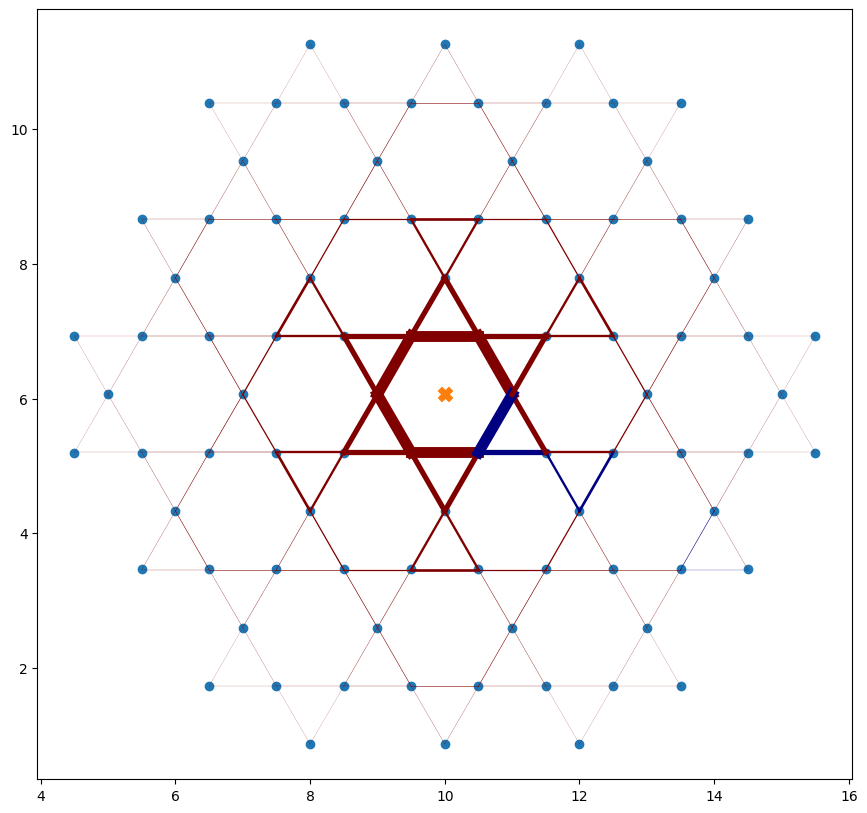

In [445]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison at triangle


In [446]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    v_pt=np.array([11, 19/3 * height]),
    visonBonds_vs = [
                 np.array([[10.5, 6 * height], [11.5, 6. * height]]), 
              np.array([[11.5, 6. * height], [12.,  5 * height]]), 
              np.array([[12.,  5 * height], [12.5, 6 *height]]), 
              np.array([[13.5, 4 *height], [14, 5 * height]]),
                     np.array([[13.5, 4 *height], [14.5, 4 * height]]),
              ]
)              
visonBonds_idx = []
# print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

# print(f"final value of Q_init is {Q_init}")

In [447]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

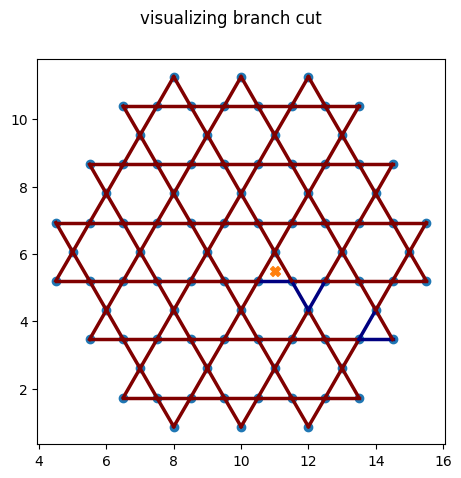

In [448]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [449]:
bonds_dict

{'[[7.5  1.73]\n [6.5  1.73]]': 0,
 '[[7.5  1.73]\n [8.5  1.73]]': 1,
 '[[7.5  1.73]\n [8.   0.87]]': 2,
 '[[7.5  1.73]\n [7.   2.6 ]]': 3,
 '[[9.5  1.73]\n [8.5  1.73]]': 4,
 '[[ 9.5   1.73]\n [10.5   1.73]]': 5,
 '[[ 9.5   1.73]\n [10.    0.87]]': 6,
 '[[9.5  1.73]\n [9.   2.6 ]]': 7,
 '[[11.5   1.73]\n [10.5   1.73]]': 8,
 '[[11.5   1.73]\n [12.5   1.73]]': 9,
 '[[11.5   1.73]\n [12.    0.87]]': 10,
 '[[11.5   1.73]\n [11.    2.6 ]]': 11,
 '[[13.5   1.73]\n [12.5   1.73]]': 12,
 '[[13.5   1.73]\n [13.    2.6 ]]': 13,
 '[[6.5  3.46]\n [5.5  3.46]]': 14,
 '[[6.5  3.46]\n [7.5  3.46]]': 15,
 '[[6.5  3.46]\n [7.   2.6 ]]': 16,
 '[[6.5  3.46]\n [6.   4.33]]': 17,
 '[[8.5  3.46]\n [7.5  3.46]]': 18,
 '[[8.5  3.46]\n [9.5  3.46]]': 19,
 '[[8.5  3.46]\n [9.   2.6 ]]': 20,
 '[[8.5  3.46]\n [8.   4.33]]': 21,
 '[[10.5   3.46]\n [ 9.5   3.46]]': 22,
 '[[10.5   3.46]\n [11.5   3.46]]': 23,
 '[[10.5   3.46]\n [11.    2.6 ]]': 24,
 '[[10.5   3.46]\n [10.    4.33]]': 25,
 '[[12.5   3.46]\n [11.5  

In [450]:
results_gs['x']

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [451]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy(couplings, Q_init_vs, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

/Users/yan/Repositories/rydberg-vison/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 205, function evaluations: 46292, CG iterations: 2568, optimality: 5.18e-07, constraint violation: 0.00e+00, execution time: 1.2e+03 s.


In [452]:
energy_Q(Q_init)

-26.5

In [453]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-44.29932322336614
True
`xtol` termination condition is satisfied.
2


array([ 0.76324868,  0.73804666,  0.76325172,  0.73804311,  0.78924701,
        0.73981677,  0.76553201,  0.76710131,  0.78953854,  0.73821215,
        0.76331412,  0.76825882,  0.76333688,  0.76333693,  0.76546533,
        0.76701931,  0.78924525,  0.73964445,  0.7690274 ,  0.76883434,
        0.76883605,  0.76902577,  0.76287093,  0.77450288,  0.76858853,
        0.76898155,  0.76491164,  0.76854463,  0.76800281,  0.76546318,
       -0.76575881,  0.76575882,  0.76323843,  0.76776615,  0.7891563 ,
        0.73805024,  0.76791648,  0.76619348,  0.76678395,  0.7673299 ,
        0.76298677,  0.72531402,  0.71813496,  0.76843711, -0.60362084,
        0.72577162, -0.72577165,  0.60362092,  0.76546326,  0.76800291,
        0.7685446 ,  0.76491161,  0.7633369 ,  0.76333692,  0.76323821,
        0.76323821,  0.76776216,  0.76789449,  0.76873153,  0.76692038,
        0.76642854,  0.76604033,  0.76604032,  0.76642854,  0.76843712,
        0.71813495,  0.72531408,  0.76298677,  0.76898152,  0.76

In [454]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [455]:
results_gs['x']

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [456]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [457]:
Q0_results

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [458]:
Q_init_vs

array([ 0.76323916,  0.73805743,  0.76323895,  0.73805708,  0.78914443,
        0.73965987,  0.76545551,  0.76692733,  0.78914503,  0.73805772,
        0.76323947,  0.76775875,  0.7632395 ,  0.76323916,  0.76545706,
        0.76692838,  0.78914549,  0.73965994,  0.76865152,  0.76715441,
        0.7686512 ,  0.76715455,  0.76660139,  0.76715514,  0.76782397,
        0.76592777,  0.7686512 ,  0.76692704,  0.76775836,  0.76782382,
       -0.76545649,  0.76545649,  0.76323954,  0.76775805,  0.78914527,
        0.73805741,  0.7678239 ,  0.76592752,  0.76660076,  0.76715528,
        0.76527545,  0.76541227,  0.76527576,  0.7654117 , -0.7652762 ,
        0.76592681, -0.76592759,  0.76527582,  0.76782461,  0.76775924,
        0.76692744,  0.76865079,  0.76323924,  0.76323932,  0.76323874,
        0.76323981,  0.76775828,  0.76782455,  0.76865072,  0.76692759,
        0.76592728,  0.76527637,  0.76527582,  0.76592704,  0.7654117 ,
        0.76527541,  0.76541145,  0.76527562,  0.76592714,  0.76

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

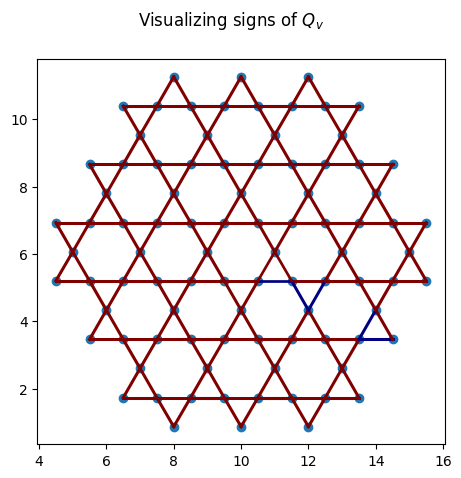

In [459]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [460]:
Qv_results - Q0_results

array([ 9.51689208e-06, -1.07732688e-05,  1.27734650e-05, -1.39745721e-05,
        1.02576219e-04,  1.56896177e-04,  7.65046855e-05,  1.73981090e-04,
        3.93504471e-04,  1.54427469e-04,  7.46521297e-05,  5.00070376e-04,
        9.73729163e-05,  9.77733877e-05,  8.27431708e-06,  9.09298969e-05,
        9.97604716e-05, -1.54948637e-05,  3.75881956e-04,  1.67992603e-03,
        1.84844649e-04,  1.87122338e-03, -3.73045428e-03,  7.34773961e-03,
        7.64561100e-04,  3.05378271e-03, -3.73955142e-03,  1.61758901e-03,
        2.44456671e-04, -2.36064385e-03, -1.53121530e+00,  3.02326022e-04,
       -1.11034742e-06,  8.09957712e-06,  1.10335172e-05, -7.17666421e-06,
        9.25727691e-05,  2.65963083e-04,  1.83188270e-04,  1.74615061e-04,
       -2.28868022e-03, -4.00982459e-02, -4.71407999e-02,  3.02540506e-03,
       -1.36889704e+00, -4.01551933e-02, -1.49169924e+00, -1.61654904e-01,
       -2.36135277e-03,  2.43669381e-04,  1.61715520e-03, -3.73918828e-03,
        9.76588675e-05,  

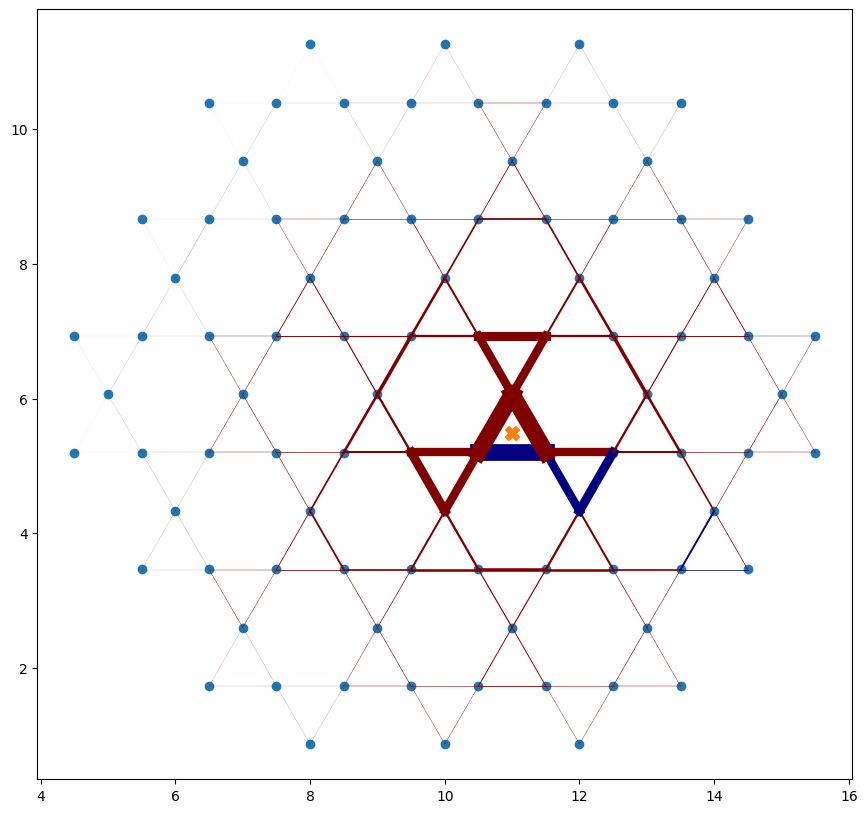

In [462]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')